In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os 
import sys
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)
import statistics as stats
from uncertainties import ufloat
import math

In [2]:
hdu = fits.open('/Users/quinncasey/Desktop/research/eboss/spLine_trim_dr16_eboss.fits')

In [3]:
ha = hdu[1].data['H_ALPHA_FLUX'].tolist()
ha_err = hdu[1].data['H_ALPHA_FLUX_ERR'].tolist()
hb = hdu[1].data['H_BETA_FLUX'].tolist()
hb_err = hdu[1].data['H_BETA_FLUX_ERR'].tolist()
o3 = hdu[1].data['OIII_5007_FLUX'].tolist()
o3_err = hdu[1].data['OIII_5007_FLUX_ERR'].tolist()
n2 = hdu[1].data['NII_6584_FLUX'].tolist()
n2_err = hdu[1].data['NII_6584_FLUX_ERR'].tolist()

z = hdu[1].data['Z'].tolist()

In [4]:
data_names = ['ha', 'ha_err', 'hb', 'hb_err', 'o3', 'o3_err', 'n2', 'n2_err', 'z']
data_dict = {'ha':ha, 'ha_err':ha_err, 'hb':hb, 'hb_err':hb_err, 'o3':o3, 
            'o3_err':o3_err, 'n2':n2, 'n2_err':n2_err, 'z':z}
df = pd.DataFrame(data_dict)

In [5]:
for name in data_names: 
    df = df.loc[df[name].notnull()]

In [6]:
df = df.loc[(df['ha']/df['ha_err']) > 3]
df = df.loc[(df['hb']/df['hb_err']) > 3]
df = df.loc[(df['n2']/df['n2_err']) > 3]
df = df.loc[(df['o3']/df['o3_err']) > 3]

df = df.query('z > 0.3 & z <=0.4')

In [7]:
def low_met_agn(df): 
    x_values = df.x.values
    y_values = df.y.values.tolist()
    
    z_1 = df['z'].values
    ha_1 = df['ha'].values
    ha_err_1 = df['ha_err'].values
    hb_1 = df['hb'].values
    hb_err_1 = df['hb_err'].values
    o3_1 = df['o3'].values
    o3_err_1 = df['o3_err'].values
    n2_1 = df['n2'].values
    n2_err_1 = df['n2_err'].values
    
    
    kewl_agn_class_line_mod = (0.61/(x_values-0.02-0.1833*(df.loc[:,"z"].median())))+1.4+0.03*(df.loc[:,"z"].median())
    
    df = []
    
    for x, y, agn_line in zip(x_values, y_values, kewl_agn_class_line_mod):
        if x < -0.8 and y > agn_line:
            df.append('lowmetagn')
        elif x >=-0.8 and y > agn_line:
            df.append('agn')
        elif x > 0.0:
            df.append('agn')
        else: 
            df.append('starform')
            
    return df, ha_1, ha_err_1, hb_1, hb_err_1, n2_1, n2_err_1, o3_1, o3_err_1, z_1

In [8]:
df['x'] = np.log10(df['n2']/df['ha'])
df['y'] = np.log10(df['o3']/df['hb'])

df1 = low_met_agn(df)

In [9]:
df1 = pd.DataFrame(df1)
df1 = df1.transpose()
df1.columns = ['Type', 'ha', 'ha_err', 'hb', 'hb_err', 'n2', 'n2_err', 'o3', 'o3_err', 'z']

In [10]:
dfagn = df1[df1.Type != 'starform']
dfsf = df1[df1.Type != 'agn']
dflowmetagn = df1[df1.Type != 'agn']

dfagn = dfagn[dfagn.Type != 'lowmetagn']
dfsf = dfsf[dfsf.Type != 'lowmetagn']
dflowmetagn = dflowmetagn[dflowmetagn.Type != 'starform']

In [11]:
print(len(dfagn))
print(len(dfsf))
print(len(dflowmetagn))

5148
8303
5


In [12]:
dfsf = dfsf.drop(columns=['ha', 'ha_err', 'hb', 'hb_err', 'n2', 'n2_err'])
dfagn = dfagn.drop(columns=['ha', 'ha_err', 'hb', 'hb_err', 'n2', 'n2_err'])
dflowmetagn = dflowmetagn.drop(columns=['ha', 'ha_err', 'hb', 'hb_err', 'n2', 'n2_err'])

In [13]:
d_MPC = cosmo.luminosity_distance(dflowmetagn['z'])
dflowmetagn['d (MPC)'] = d_MPC

In [14]:
d_MPC = cosmo.luminosity_distance(dfsf['z'])
dfsf['d (MPC)'] = d_MPC

In [15]:
d_MPC = cosmo.luminosity_distance(dfagn['z'])
dfagn['d (MPC)'] = d_MPC

In [16]:
dflowmetagn['d (cm)'] = dflowmetagn['d (MPC)']*3.08567758128E+24
dfsf['d (cm)'] = dfsf['d (MPC)']*3.08567758128E+24
dfagn['d (cm)'] = dfagn['d (MPC)']*3.08567758128E+24

In [17]:
def lumin(oxy3, d_cm):
    L = (oxy3)*(4)*(np.pi)*(d_cm**2)
    return L

In [18]:
dflowmetagn['luminosity_non_bolo'] = lumin(dflowmetagn['o3'], dflowmetagn['d (cm)'])
dfsf['luminosity_non_bolo'] = lumin(dfsf['o3'], dfsf['d (cm)'])
dfagn['luminosity_non_bolo'] = lumin(dfagn['o3'], dfagn['d (cm)'])

In [19]:
dflowmetagn['luminosity_non_bolo'] = dflowmetagn.luminosity_non_bolo.astype(float)
#dflowmetagn['luminosity_log10'] = np.log10(dflowmetagn['luminosity_non_bolo'])

dfsf['luminosity_non_bolo'] = dfsf.luminosity_non_bolo.astype(float)
#dflowmetagn['luminosity_log10'] = np.log10(dflowmetagn['luminosity_non_bolo'])

dfagn['luminosity_non_bolo'] = dfagn.luminosity_non_bolo.astype(float)
#dflowmetagn['luminosity_log10'] = np.log10(dflowmetagn['luminosity_non_bolo'])

In [20]:
def bolo_lumin(L_o3):
    L_iso_exp = ((0.5617)*(np.log10(L_o3)))+(22.186)
    #L_iso = np.log10(L_iso_exp)
    return L_iso_exp

In [21]:
bolo_non_log_lowmetagn = bolo_lumin(dflowmetagn['luminosity_non_bolo'])
dflowmetagn['log(bolo_lumin)'] = bolo_non_log_lowmetagn
bolo_lumin_lowmetagn = np.log10(bolo_non_log_lowmetagn)
dflowmetagn['Bolo_Lumin'] = bolo_lumin_lowmetagn

dflowmetagn['log(o3_lumin)'] = np.log10(dflowmetagn['luminosity_non_bolo'])
dflowmetagn

,Type,o3,o3_err,z,d (MPC),d (cm),luminosity_non_bolo,log(bolo_lumin),Bolo_Lumin,log(o3_lumin)
3478,lowmetagn,345.044,3.90225,0.307721,1598.9,4.9337e+27,1.055430e+59,55.339460,1.743035,59.023429
4345,lowmetagn,106.181,2.14711,0.379295,2040.27,6.29562e+27,5.288512e+58,55.170896,1.741710,58.723333
9213,lowmetagn,170.264,1.85935,0.368212,1970.46,6.08021e+27,7.909890e+58,55.269102,1.742482,58.898170
10681,lowmetagn,407.636,3.26209,0.325239,1704.82,5.26052e+27,1.417553e+59,55.411420,1.743599,59.151539
12063,lowmetagn,311.854,3.98772,0.377046,2026.07,6.25178e+27,1.531682e+59,55.430309,1.743747,59.185169


In [22]:
bolo_non_log_sf = bolo_lumin(dfsf['luminosity_non_bolo'])
dfsf['log(bolo_lumin)'] = bolo_non_log_sf
bolo_lumin_sf = np.log10(bolo_non_log_sf)
dfsf['Bolo_Lumin'] = bolo_lumin_sf

dfsf['log(o3_lumin)'] = np.log10(dfsf['luminosity_non_bolo'])
dfsf

,Type,o3,o3_err,z,d (MPC),d (cm),luminosity_non_bolo,log(bolo_lumin),Bolo_Lumin,log(o3_lumin)
0,starform,3.24647,0.784433,0.392385,2123.4,6.55212e+27,1.751397e+57,54.339609,1.735117,57.243385
1,starform,3.76393,0.900469,0.392467,2123.92,6.55374e+27,2.031558e+57,54.375808,1.735406,57.307829
2,starform,5.54276,1.21307,0.300204,1553.89,4.79481e+27,1.601325e+57,54.317756,1.734942,57.204480
3,starform,3.13454,0.970009,0.392458,2123.87,6.55357e+27,1.691758e+57,54.331158,1.735049,57.228338
5,starform,3.04002,0.795788,0.392319,2122.98,6.55082e+27,1.639374e+57,54.323485,1.734988,57.214678
...,...,...,...,...,...,...,...,...,...,...
13450,starform,8.38577,0.854823,0.306856,1593.71,4.91768e+27,2.548432e+57,54.431104,1.735847,57.406273
13451,starform,9.568,1.139,0.318917,1666.43,5.14208e+27,3.179126e+57,54.485046,1.736277,57.502308
13453,starform,30.1978,1.01528,0.368672,1973.34,6.0891e+27,1.406994e+58,54.847896,1.739160,58.148292
13454,starform,5.75105,0.79639,0.396967,2152.66,6.64242e+27,3.188672e+57,54.485778,1.736283,57.503610


In [23]:
bolo_non_log_agn = bolo_lumin(dfagn['luminosity_non_bolo'])
dfagn['log(bolo_lumin)'] = bolo_non_log_agn
bolo_lumin_agn = np.log10(bolo_non_log_agn)
dfagn['Bolo_Lumin'] = bolo_lumin_agn

dfagn['log(o3_lumin)'] = np.log10(dfagn['luminosity_non_bolo'])
dfagn

,Type,o3,o3_err,z,d (MPC),d (cm),luminosity_non_bolo,log(bolo_lumin),Bolo_Lumin,log(o3_lumin)
4,agn,4.04306,0.933961,0.394468,2136.69,6.59314e+27,2.208535e+57,54.396183,1.735568,57.344104
13,agn,7.76032,1.2216,0.33687,1775.91,5.47989e+27,2.928422e+57,54.465008,1.736118,57.466634
25,agn,6.95651,1.01148,0.351828,1868.22,5.76473e+27,2.905085e+57,54.463056,1.736102,57.463159
35,agn,25.6842,1.45674,0.390232,2109.68,6.50979e+27,1.367759e+58,54.840997,1.739105,58.136009
42,agn,18.7719,1.01282,0.326315,1711.37,5.28074e+27,6.578197e+57,54.662431,1.737689,57.818107
...,...,...,...,...,...,...,...,...,...,...
13411,agn,5.78206,0.93058,0.320719,1677.36,5.17578e+27,1.946453e+57,54.365368,1.735322,57.289244
13413,agn,9.4734,1.19908,0.357702,1904.74,5.87742e+27,4.112338e+57,54.547834,1.736778,57.614089
13422,agn,3.7649,1.16069,0.34069,1799.39,5.55233e+27,1.458527e+57,54.294971,1.734760,57.163914
13438,agn,4.87849,1.03227,0.304372,1578.82,4.87172e+27,1.454989e+57,54.294378,1.734755,57.162860


In [24]:
log_bolometric_lowmetagn = dflowmetagn['log(bolo_lumin)']
log_bolometric_sf = dfsf['log(bolo_lumin)']
log_bolometric_agn = dfagn['log(bolo_lumin)']

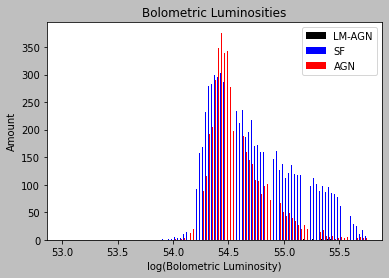

In [25]:
plt.style.use('grayscale')
bins = np.linspace(53, 55.75, 100)
colors = ['k', 'b', 'r']
plt.hist([log_bolometric_lowmetagn, log_bolometric_sf, log_bolometric_agn], bins, label=['LM-AGN', 'SF', 'AGN'], color=colors)

plt.legend(loc='upper right')
plt.title('Bolometric Luminosities')
plt.xlabel('log(Bolometric Luminosity)')
plt.ylabel('Amount')
plt.show()

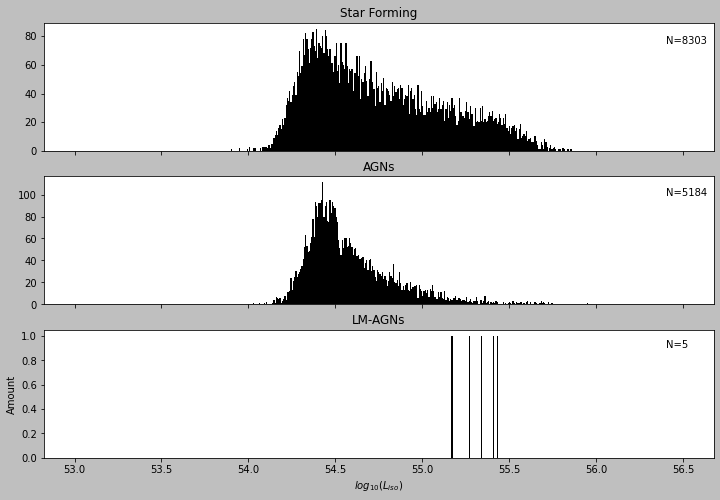

In [32]:
plt.style.use('grayscale')
fig, axs = plt.subplots(3, sharex=True, sharey=False, figsize=(12, 8))
bins = np.linspace(53, 56.5, 500)

sf_hist = axs[0].hist(log_bolometric_sf, bins=bins)
axs[0].set_title('Star Forming')
agn_hist = axs[1].hist(log_bolometric_agn, bins=bins)
axs[1].set_title('AGNs')
lm_agn_hist = axs[2].hist(log_bolometric_lowmetagn, bins=bins)
axs[2].set_title('LM-AGNs')

plt.text(56.4, 3.4, 'N=8303')
plt.text(56.4, 2.15, 'N=5184')
plt.text(56.4, 0.9, 'N=5')

plt.xlabel(r'$log_{10}(L_{iso})$')
plt.ylabel('Amount')
plt.show()

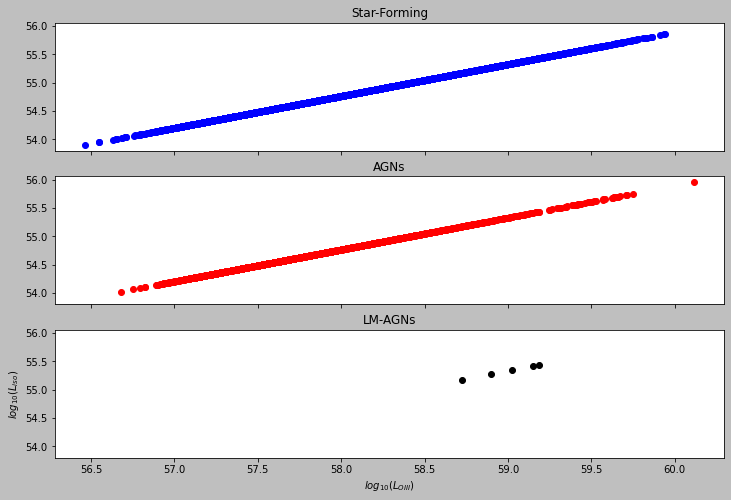

In [27]:
plt.style.use('grayscale')
fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize=(12, 8))

sf_scatter = axs[0].scatter(dfsf['log(o3_lumin)'], dfsf['log(bolo_lumin)'], c='b')
axs[0].set_title('Star-Forming')
agn_scatter = axs[1].scatter(dfagn['log(o3_lumin)'], dfagn['log(bolo_lumin)'], c='r')
axs[1].set_title('AGNs')
lm_agn_scatter = axs[2].scatter(dflowmetagn['log(o3_lumin)'], dflowmetagn['log(bolo_lumin)'], c='k')
axs[2].set_title('LM-AGNs')

plt.ylabel(r'$log_{10}(L_{iso})$')
plt.xlabel(r'$log_{10}(L_{OIII})$')
plt.show()